# Préparation & preprocessing

In [2]:
# ---
# 1) Préparation : on charge le jeu de données et on prépare les features
# Idée : pour du clustering, on transforme tout en numérique (OneHot + StandardScaler)
# ---

import os, urllib.request, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Dataset
CSV_NAME = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"

# Chargement + petit nettoyage (on supprime juste les colonnes inutiles)
df = pd.read_csv(CSV_NAME).copy()
drop_cols = [c for c in ["EmployeeCount","Over18","StandardHours","EmployeeNumber"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Pour le clustering, on retire la cible si elle existe (on ne veut pas "forcer" des groupes)
X_clust = df.drop(columns=["Attrition"]) if "Attrition" in df.columns else df.copy()

# Colonnes catégorielles / numériques
cat_cols = [c for c in X_clust.columns if X_clust[c].dtype == "object"]
num_cols = [c for c in X_clust.columns if c not in cat_cols]

# Préprocesseur : encode les catégories et normalise les numériques
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # compat versions plus anciennes

prepro = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("num", StandardScaler(), num_cols)
])

# Matrice transformée (toutes features numériques et comparables entre elles)
Xmat = prepro.fit_transform(X_clust)

print(f"Matrice de clustering : {Xmat.shape[0]} lignes x {Xmat.shape[1]} colonnes")

Matrice de clustering : 1470 lignes x 51 colonnes


# Choisir un K raisonnable (Silhouette + Coude)

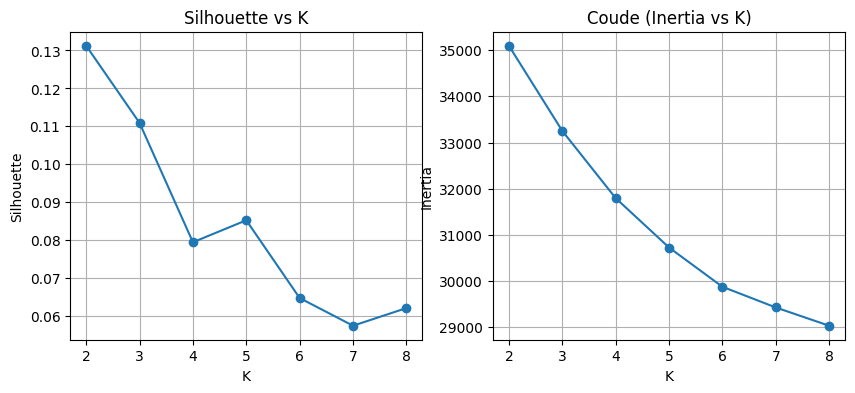

Lecture simple :
- Silhouette max vers K faible (souvent K=2/3).
- Coude souvent vers K=4/5 (compromis variance/complexité).


In [3]:
# ---
# 2) On teste plusieurs valeurs de K (2 → 8)
# - Silhouette : plus c'est haut, mieux les groupes sont séparés
# - Inertia (coude) : plus ça baisse vite au début, meilleur est le K du "coude"
# ---

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Ks = range(2, 9)
sil_scores, inertias = [], []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(Xmat)
    sil_scores.append(silhouette_score(Xmat, km.labels_))
    inertias.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, sil_scores, marker="o")
plt.title("Silhouette vs K"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Ks, inertias, marker="o")
plt.title("Coude (Inertia vs K)"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.grid(True)
plt.show()

# Rappel simple pour la suite :
print("Lecture simple :")
print("- Silhouette max vers K faible (souvent K=2/3).")
print("- Coude souvent vers K=4/5 (compromis variance/complexité).")

# Visualiser des clusters concrets (K=2 et K=5) avec PCA 2D

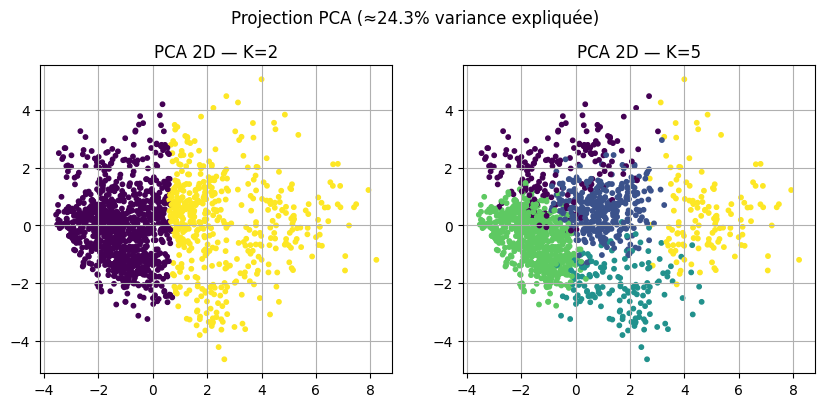

In [4]:
# ---
# 3) On regarde 2 segmentations concrètes :
# - K=2 : séparation très simple (ex: juniors vs seniors)
# - K=5 : plus granulaire et souvent plus actionnable côté RH
# On projette en 2D (PCA) pour "voir" les groupes.
# ---

from sklearn.decomposition import PCA

kmeans2 = KMeans(n_clusters=2, n_init=10, random_state=42).fit(Xmat)
labels2 = kmeans2.labels_

kmeans5 = KMeans(n_clusters=5, n_init=10, random_state=42).fit(Xmat)
labels5 = kmeans5.labels_

# PCA 2D (juste pour visualiser, ça ne sert pas à entraîner)
pca = PCA(n_components=2, random_state=42).fit(Xmat)
Z = pca.transform(Xmat)
expl = pca.explained_variance_ratio_.sum()*100

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(Z[:,0], Z[:,1], c=labels2, s=10)
plt.title("PCA 2D — K=2"); plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(Z[:,0], Z[:,1], c=labels5, s=10)
plt.title("PCA 2D — K=5")
plt.grid(True); plt.suptitle(f"Projection PCA (≈{expl:.1f}% variance expliquée)", y=1.02)
plt.show()

# Profiler chaque cluster (moyennes numériques + catégorie dominante)

In [5]:
# ---
# 4) On crée un petit "profil" par cluster :
# - Count : taille du groupe
# - Moyenne des variables numériques (âge, ancienneté, etc.)
# - Catégorie dominante (ex: JobRole le plus fréquent)
# Ce tableau est parfait pour les slides.
# ---

def describe_clusters(df_ref, labels, num_cols, cat_cols):
    tmp = df_ref.copy()
    tmp["Cluster"] = labels
    rows = []
    for k, sub in tmp.groupby("Cluster"):
        row = {"Cluster": int(k), "Count": int(len(sub))}
        for c in num_cols:
            row[f"mean_{c}"] = float(sub[c].mean())
        for c in cat_cols:
            vc = sub[c].value_counts(normalize=True, dropna=False)
            if not vc.empty:
                row[f"top_{c}"] = str(vc.index[0])
                row[f"top_{c}_pct"] = round(float(vc.iloc[0]), 3)
        rows.append(row)
    return pd.DataFrame(rows).sort_values("Cluster").reset_index(drop=True)

profiles2 = describe_clusters(X_clust, labels2, num_cols, cat_cols)
profiles5 = describe_clusters(X_clust, labels5, num_cols, cat_cols)

print("=== Profils K=2 ===")
try: display(profiles2)
except: print(profiles2)

print("\n=== Profils K=5 ===")
try: display(profiles5)
except: print(profiles5)

=== Profils K=2 ===


,Cluster,Count,mean_Age,mean_DailyRate,mean_DistanceFromHome,mean_Education,mean_EnvironmentSatisfaction,mean_HourlyRate,mean_JobInvolvement,mean_JobLevel,...,top_EducationField,top_EducationField_pct,top_Gender,top_Gender_pct,top_JobRole,top_JobRole_pct,top_MaritalStatus,top_MaritalStatus_pct,top_OverTime,top_OverTime_pct
0,0,995,34.123618,804.993970,9.182915,2.832161,2.699497,66.006030,2.726633,1.532663,...,Life Sciences,0.409,Male,0.609,Research Scientist,0.267,Married,0.431,No,0.712
1,1,475,42.789474,797.231579,9.212632,3.082105,2.768421,65.650526,2.736842,3.176842,...,Life Sciences,0.419,Male,0.581,Sales Executive,0.267,Married,0.514,No,0.728



=== Profils K=5 ===


,Cluster,Count,mean_Age,mean_DailyRate,mean_DistanceFromHome,mean_Education,mean_EnvironmentSatisfaction,mean_HourlyRate,mean_JobInvolvement,mean_JobLevel,...,top_EducationField,top_EducationField_pct,top_Gender,top_Gender_pct,top_JobRole,top_JobRole_pct,top_MaritalStatus,top_MaritalStatus_pct,top_OverTime,top_OverTime_pct
0,0,189,34.862434,800.280423,9.846561,2.798942,2.645503,65.698413,2.714286,1.661376,...,Life Sciences,0.450,Male,0.598,Research Scientist,0.254,Married,0.460,No,0.693
1,1,337,36.157270,793.456973,9.424332,3.053412,2.821958,63.890208,2.768546,2.083086,...,Life Sciences,0.404,Male,0.605,Sales Executive,0.344,Married,0.472,No,0.766
2,2,148,48.912162,878.162162,9.317568,3.135135,2.716216,67.040541,2.797297,3.628378,...,Life Sciences,0.405,Male,0.568,Research Director,0.264,Married,0.480,No,0.676
3,3,665,33.378947,800.479699,8.933835,2.806015,2.717293,66.766917,2.721805,1.437594,...,Life Sciences,0.411,Male,0.620,Research Scientist,0.278,Married,0.436,No,0.707
4,4,131,46.320611,753.580153,8.824427,3.007634,2.603053,65.572519,2.618321,4.007634,...,Life Sciences,0.397,Male,0.527,Manager,0.427,Married,0.504,No,0.725


# Donner des noms “métier” aux clusters (K=5) pour raconter une histoire

In [6]:
# ---
# 5) Donner des NOMS clairs aux clusters K=5.
# Idée : traduire "Cluster 0/1/2..." en "Jeunes scientifiques", "Commerciaux milieu carrière", etc.
# On se base sur quelques signaux faciles (âge, ancienneté, niveau, rôle dominant).
# ---

ROLE_MAP = {
    "Research Scientist": "scientifiques",
    "Research Director":  "directeurs R&D",
    "Laboratory Technician": "techniciens",
    "Manager": "managers",
    "Manufacturing Director": "directeurs production",
    "Healthcare Representative": "représentants santé",
    "Sales Executive": "commerciaux",
    "Sales Representative": "commerciaux",
    "Human Resources": "RH",
}

def bucket_age(m):
    if np.isnan(m): return None
    if m < 35: return "Jeunes"
    if m > 45: return "Seniors"
    return "Milieu carrière"

def bucket_tenure(m):
    if np.isnan(m): return None
    if m < 3: return "Nouveaux"
    if m > 8: return "Ancienneté élevée"
    return "Exp. moyenne"

def propose_name(sub):
    age = sub["Age"].mean() if "Age" in sub else np.nan
    yac = sub["YearsAtCompany"].mean() if "YearsAtCompany" in sub else np.nan
    jl  = sub["JobLevel"].mean() if "JobLevel" in sub else np.nan
    role = sub["JobRole"].value_counts().idxmax() if "JobRole" in sub else None
    role_name = ROLE_MAP.get(role, None)

    parts = []
    a = bucket_age(age)
    t = bucket_tenure(yac)
    if a: parts.append(a)
    if role_name: parts.append(role_name)
    else:
        parts.append("job level élevé" if (not np.isnan(jl) and jl>=3) else "job level bas")
    if t: parts.append(t)

    # on garde court → 2 morceaux max pour le nom, le reste ira en “tagline”
    name = " ".join(parts[:2]).capitalize()
    tagline = " • ".join(parts[2:4])
    return name, tagline

# On applique sur K=5
df_k5 = X_clust.copy()
df_k5["Cluster"] = labels5

names = {}
for k, sub in df_k5.groupby("Cluster"):
    n, tag = propose_name(sub)
    names[int(k)] = {"name": n, "tag": tag}

# Tableau final : nom + effectif (parfait pour slides)
summary = []
for k, sub in df_k5.groupby("Cluster"):
    summary.append({
        "Cluster": int(k),
        "Nom": names[int(k)]["name"],
        "Tag": names[int(k)]["tag"],
        "Effectif": int(sub.shape[0])
    })

summary = pd.DataFrame(summary).sort_values("Cluster").reset_index(drop=True)
summary

,Cluster,Nom,Tag,Effectif
0,0,Jeunes scientifiques,Exp. moyenne,189
1,1,Milieu carrière commerciaux,Ancienneté élevée,337
2,2,Seniors directeurs r&d,Exp. moyenne,148
3,3,Jeunes scientifiques,Exp. moyenne,665
4,4,Seniors managers,Ancienneté élevée,131
